<a href="https://colab.research.google.com/github/jean-ivy/cond_text_vae_project/blob/master/TextCondVAE_PASCAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
%load_ext autoreload
%autoreload 2

In [1]:
print("Hello")

Hello


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext import data
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

import cv2

import re
import pandas as pd
import numpy as np

import os
from random import randint
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import Image, display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# Download dataset
pascal_dataset = "https://drive.google.com/open?id=14rEOVH5vUKJPtmhHYjCYb1X5T6ilRjGn"
fluff, id = pascal_dataset.split('=')

In [0]:
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('pascal_dataset.zip')  

In [0]:
!unzip "pascal_dataset"

Archive:  pascal_dataset.zip
replace pascal_dataset/aeroplane/2008_000716/image.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: pascal_dataset/aeroplane/2008_000716/image.jpg  
replace pascal_dataset/aeroplane/2008_000716/description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pascal_dataset/aeroplane/2008_000716/description.txt  
  inflating: pascal_dataset/aeroplane/2008_001227/image.jpg  
  inflating: pascal_dataset/aeroplane/2008_001227/description.txt  
  inflating: pascal_dataset/aeroplane/2008_001380/image.jpg  
  inflating: pascal_dataset/aeroplane/2008_001380/description.txt  
  inflating: pascal_dataset/aeroplane/2008_001448/image.jpg  
  inflating: pascal_dataset/aeroplane/2008_001448/description.txt  
  inflating: pascal_dataset/aeroplane/2008_001468/image.jpg  
  inflating: pascal_dataset/aeroplane/2008_001468/description.txt  
  inflating: pascal_dataset/aeroplane/2008_001801/image.jpg  
  inflating: pascal_dataset/aeroplane/2008_001801/description

In [0]:
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
TEXT = data.Field()
LABEL = data.LabelField(dtype = torch.float)

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
folder_name = r"pascal_dataset"

In [0]:
word_description = {}
for folder_cls in os.listdir(folder_name):
    folder_cls_path = os.path.join(folder_name, folder_cls)
    for example in os.listdir(folder_cls_path):
        example_path = os.path.join(folder_cls_path, example)
        txt_path = os.path.join(example_path, "description.txt")
        full_name = "{}_{}".format(folder_cls, example)
        with open(txt_path, "r") as f:
            word_description[full_name] = f.read().strip().split('\n')

In [0]:
# Text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

In [0]:
lemmatizer = WordNetLemmatizer() 

In [0]:
for img_name, text_info in word_description.items():
    for i, sent in enumerate(text_info):
        lemmatized_sent = []
        for idx, word in enumerate(text_prepare(sent).split()):
          lemmatized_sent.append(lemmatizer.lemmatize(word))
        text_info[i] = lemmatized_sent

In [0]:
flat_text = [item for sublist in list(word_description.values()) for item in sublist]
flat_text = [item for sublist in flat_text for item in sublist]

In [0]:
vocab = {'<BOS>':0, '<EOS>':1, '<UNK>':2, '<PAD>':3}
count = 4
for word in flat_text:
  if word not in vocab:
    vocab[word] = count
    count += 1

In [0]:
len(vocab)

2895

In [0]:
#MAX_VOCAB_SIZE = 25_000

#TEXT.build_vocab(train_data, 
#                 max_size = MAX_VOCAB_SIZE, 
#                 vectors = "glove.6B.100d", 
#                 unk_init = torch.Tensor.normal_)

In [0]:
image_description = {}
for folder_cls in os.listdir(folder_name):
    folder_cls_path = os.path.join(folder_name, folder_cls)
    for example in os.listdir(folder_cls_path):
        example_path = os.path.join(folder_cls_path, example)
        image_path = os.path.join(example_path, "image.jpg")
        full_name = "{}_{}".format(folder_cls, example)
        image_description[full_name] = cv2.imread(image_path)

In [0]:
def gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

In [0]:
# Convert images to gray scale
for img_name, img in image_description.items():
    image_description[img_name] = gray(img)

In [0]:
widths = []
lengths = []
for img_name, img in image_description.items():
  lengths.append(img.shape[0])
  widths.append(img.shape[1])

In [0]:
print(min(widths), max(widths))
print(min(lengths), max(lengths))

187 500
151 500


tvmonitor_2008_007987
(360, 480)
[[ 56  51  51 ... 153 153 153]
 [ 62  59  59 ... 154 153 153]
 [ 62  61  62 ... 154 154 153]
 ...
 [ 18  19  21 ... 146 145 145]
 [ 36  37  38 ... 142 142 141]
 [ 49  49  48 ... 139 138 138]]


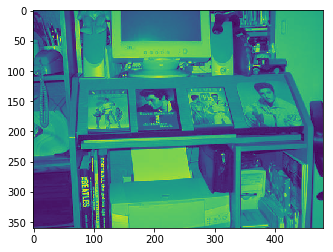

In [0]:
c = 0
for img_name, img in image_description.items():
  print(img_name)
  print(img.shape)
  print(img)
  plt.imshow(img)
  plt.show()
  c += 1 
  if c > 0:
    break
  

In [0]:
class LoadData(Dataset):
    def __init__(self, names, images, descriptions, vocab):
        self.transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomCrop(size=(500, 500), pad_if_needed=True, fill=0),
          transforms.ToTensor()])

        self.names = names
        self.images = images
        self.descriptions = descriptions
       
        self.vocab = vocab
        self.vocab_keys = vocab.keys()
        self.max_len = 50

    def __getitem__(self, index):
      
        image = self.images[self.names[index]]
        image = self.transform(image)
        description = self.descriptions[self.names[index]]
        flat_description = [item for sublist in description for item in sublist]
        
        caption = [self.vocab[token] if token in self.vocab_keys else self.vocab['<UNK>'] for token in flat_description]
        caption = [self.vocab['<BOS>']] + caption + [self.vocab['<EOS>']]
        caption = caption[:self.max_len] + (self.max_len - len(caption))*[self.vocab['<PAD>']]
        caption = torch.LongTensor(caption)
            
        return image, caption

    def __len__(self):
		    return len(self.images)

In [0]:
batch_size = 32

In [0]:
train_data_loader = LoadData(list(image_description.keys()), image_description, word_description, vocab)
train_data_iterator = DataLoader(train_data_loader, batch_size=batch_size)

In [0]:
h_dim = 1000
emb_dim = 256

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=h_dim + emb_dim):
        return input.view(input.size(0), size, 1, 1)

In [0]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, output_dim,
               n_filters, filter_sizes, dropout, pad_idx):
    
    super(TextEncoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes
                               ])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, text):

    #text = text.permute(1, 0)

    embedded = self.embedding(text)

    #embedded = embedded.unsqueeze(1)

    #conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    #pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

    #cat = self.dropout(torch.cat(pooled, dim = 1))

    #return self.fc(embedded)
    
    return torch.mean(embedded, dim=1)

In [0]:
class TextCondVAE(nn.Module):
    def __init__(self, image_channels, img_h_dim, text_h_dim, z_dim, 
                 vocab_size, emb_dim, cnn_params):
      
        super(TextCondVAE, self).__init__()

        
        """self.encoder = nn.Sequential(
            
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
            
            Flatten(),
            nn.Linear(6272, img_h_dim)
        )"""
        
        # encoder
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=4, stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.flatten = Flatten()
        self.fc_enc = nn.Linear(128 * 7 * 7, img_h_dim)
        
        # bottleneck
        self.fc1 = nn.Linear(img_h_dim + text_h_dim, z_dim)
        self.fc2 = nn.Linear(img_h_dim + text_h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, img_h_dim)
        
        # decoder
        self.unflatten = UnFlatten()
        
        self.deconv1 = nn.ConvTranspose2d(img_h_dim + text_h_dim, 128, kernel_size=7, stride=1)
        self.uppool1 = nn.MaxUnpool2d(2, stride=2)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2)
        self.uppool2 = nn.MaxUnpool2d(2, stride=2)
        
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.uppool3 = nn.MaxUnpool2d(2, stride=2)
        
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2)
        #self.uppool4 = nn.MaxUnpool2d(2, stride=2)
                               
        self.sigm = nn.Sigmoid()                       

        
        """self.decoder = nn.Sequential(
            
            UnFlatten(),
            #nn.Linear(img_h_dim + text_h_dim, 6272),
            
            nn.MaxUnpool2d(2, stride=2),            
            nn.ConvTranspose2d((img_h_dim + text_h_dim) * 4, 64, kernel_size=4, stride=2),
            nn.ReLU(),

            nn.MaxUnpool2d(2, stride=2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            
            nn.MaxUnpool2d(2, stride=2),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )"""

        self.text_encoder = TextEncoder(vocab_size, emb_dim, text_h_dim, **cnn_params)
                                       
        
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h, h_text):
        mu, logvar = self.fc1(torch.cat((h, h_text), 1)), self.fc2(torch.cat((h, h_text), 1))
          
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, h_text):
      
        #print('enc_inp', x.shape)
        out = F.relu(self.conv1(x))
        #print('conv1', out.shape)
        out, self.indices1 = self.pool1(out)
        #print('pool1', out.shape)
        
        out = F.relu(self.conv2(out))
        #print('conv2', out.shape)
        out, self.indices2 = self.pool2(out)
        #print('pool2', out.shape)
                               
        out = F.relu(self.conv3(out))
        #print('conv3', out.shape)
        out, self.indices3 = self.pool3(out)
        #print('pool3', out.shape)
        
        out = self.flatten(out)
        #print('flat', out.shape)
        h = self.fc_enc(out)
        
        #print("h", h.shape)
        #print("h_text", h_text.shape)
        z, mu, logvar = self.bottleneck(h, h_text)
        return z, mu, logvar

    def decode(self, z, h_text):      
        z = self.fc3(z)
        z = torch.cat((z, h_text), 1)
        
        #print('dec_inp', z.shape)
        out = self.unflatten(z)
        #print('un_flat', out.shape)
        
        out = F.relu(self.deconv1(out))
        #print('deconv1', out.shape)
        out = self.uppool1(out, self.indices3)
        #print('uppool1', out.shape)
        
        out = F.relu(self.deconv2(out))
        #print('deconv2', out.shape)
        out = self.uppool2(out, self.indices2)
        #print('uppool2', out.shape)
        
        out = F.relu(self.deconv3(out))
        #print('deconv3', out.shape)
        out = self.uppool3(out, self.indices1)
        #print('uppool3', out.shape)
        
        out = F.relu(self.deconv4(out))
        #print('deconv4', out.shape)
        z = self.sigm(out)
        
        return z
    
    def get_h_text(self, caption):
        return self.text_encoder(caption)
    
    def forward(self, x, caption):
        h_text = self.get_h_text(caption)
        z, mu, logvar = self.encode(x, h_text)
        z = self.decode(z, h_text)
        return z, mu, logvar

In [0]:
def loss_fn(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD, MSE, KLD

In [0]:
image_channels = 1
z_dim = 32

In [0]:
cnn_params={"n_filters":16,
            "filter_sizes":[3],
            "dropout":0.3,
            "pad_idx":0
           }

In [0]:
model = TextCondVAE(image_channels=image_channels,
                    img_h_dim=h_dim,
                    text_h_dim=emb_dim,
                    z_dim=z_dim,
                    vocab_size=len(vocab),
                    emb_dim=emb_dim,
                    cnn_params=cnn_params
                   ).to(device)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
epochs = 1000

In [0]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_bce = 0
    total_kld = 0
    print("Epoch #{}".format(epoch))
    for idx, (images, labels) in enumerate(train_data_iterator):
        images = images.cuda()
        labels = labels.cuda()
        recon_images, mu, logvar = model(images, labels)
        #print(recon_images.shape)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item() / batch_size, bce.item() / batch_size, kld.item() / batch_size)
        #print(to_print)
        total_loss += loss.item() / len(train_data_iterator)
    print(total_loss)

# notify to android when finished training
# notify(to_print, priority=1)

torch.save(model.state_dict(), 'PASCAL_vae.torch')

Epoch #0
922887.263671875
Epoch #1
922250.8852539062
Epoch #2
921930.3857421875
Epoch #3
921487.7880859375
Epoch #4
922085.6928710938
Epoch #5
921036.28125
Epoch #6
921178.498046875
Epoch #7
920374.5400390625
Epoch #8
919696.7573242188
Epoch #9
917818.5600585938
Epoch #10
917280.478515625
Epoch #11
917075.3823242188
Epoch #12
916391.6064453125
Epoch #13
916726.8002929688
Epoch #14
915208.5913085938
Epoch #15
916684.9575195312
Epoch #16
916031.359375
Epoch #17
914618.0014648438
Epoch #18
912917.2431640625
Epoch #19
914131.6440429688
Epoch #20
913636.2045898438
Epoch #21
912953.7231445312
Epoch #22
912432.353515625
Epoch #23
913208.9633789062
Epoch #24
912177.7827148438
Epoch #25
912247.4741210938
Epoch #26
911479.1762695312
Epoch #27
911122.7719726562
Epoch #28
911260.9912109375
Epoch #29
911741.0170898438
Epoch #30
911001.9921875
Epoch #31
909484.7514648438
Epoch #32
911461.5053710938
Epoch #33
909803.0981445312
Epoch #34
908829.6137695312
Epoch #35
907950.015625
Epoch #36
907706.74218

## Test reconstruction

In [0]:
model.eval()
with torch.no_grad():
  total_loss = 0
  total_bce = 0
  total_kld = 0
  for idx, (images, labels) in enumerate(t):
      labels = one_hot_embedding(labels, 10)
      images = images.cuda()
      labels = labels.cuda()
      recon_images, mu, logvar = model(images, labels)
      loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

      total_loss += loss.item() / len(test_loader)
      total_bce += bce.item() / len(test_loader)
      total_kld += kld.item() / len(test_loader)
  print(total_loss, total_bce, total_kld)

NameError: ignored

In [0]:
torch.save(model.state_dict(), '300epochs_cvae.torch')

In [0]:
import os
print( os.getcwd() )
print( os.listdir('data') )

/content
['MNIST']


In [0]:
from google.colab import files
files.download( "300epochs_cvae.torch" ) 

## Reconstruct images

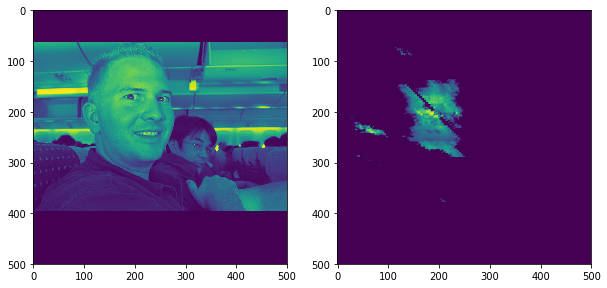

In [0]:
img = train_data_loader[randint(1, 100)]
rec_img, _, _ = model(img[0].unsqueeze(0).cuda(), img[1].unsqueeze(0).cuda())

fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(img[0].cpu().squeeze(0).squeeze(0).detach().numpy())
fig.add_subplot(rows, columns, 2)
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())

plt.show()

#save_image(compare_x.data.cpu(), 'sample_image.png')
#display(Image('sample_image.png', width=700, unconfined=True))

##Generate image

In [0]:
digit = 0
rec_img = model.decode(torch.randn(1, z_dim).cuda(), one_hot_embedding(digit, n_classes).unsqueeze(0).cuda())
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())

NameError: ignored

# VAE
